IMPORTS



In [ ]:
from google.colab import drive
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from PIL import Image
from concurrent.futures import ThreadPoolExecutor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay,precision_score,f1_score,recall_score
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

Mounting drive and defining filepaths

In [ ]:
drive.mount('/content/drive',force_remount=True)
rfid1path = '/content/drive/My Drive/Oslomet/RFMiD_1.0/'
rfid2path = '/content/drive/My Drive/Oslomet/RFMiD_2.0/'
train='Training_set/'
val='Validation_set/'
test='Test_set/'

Mounted at /content/drive


Loading in the labels from rfmid1

In [ ]:
rf1_train_labels=pd.read_csv(rfid1path+train+'RFMiD_1_Training_labels.csv')
rf1_val_labels=pd.read_csv(rfid1path+val+'RFMiD_1_Validation_labels.csv')
rf1_test_labels=pd.read_csv(rfid1path+test+'RFMiD_1_Testing_labels.csv')

Loading in the labels from rfmid2

In [ ]:
rf2_train_labels=pd.read_csv(rfid2path+train+'RFMiD_2_Training_labels.csv')
rf2_val_labels=pd.read_csv(rfid2path+val+'RFMiD_2_Validation_labels.csv')
rf2_test_labels=pd.read_csv(rfid2path+test+'RFMiD_2_Testing_labels.csv')

Adding missing columns to each dataset

In [ ]:
for col in rf2_train_labels.columns:
    if col not in rf1_train_labels.columns:
        rf1_train_labels[col]=0
        rf1_val_labels[col]=0
        rf1_test_labels[col]=0

for col in rf1_train_labels.columns:
    if col not in rf2_train_labels.columns:
        rf2_train_labels[col]=0
        rf2_val_labels[col]=0
        rf2_test_labels[col]=0

Combining the labels from both datasets

In [ ]:
y = pd.concat([rf1_train_labels, rf2_train_labels,rf1_val_labels,rf2_val_labels,rf1_test_labels,rf2_test_labels], ignore_index=True)
y.drop(columns=['ID'],inplace=True)


Functions for loading in images and transforming to 3D numpy matrices, optimized with multithreading

In [ ]:
def process_image(file_path, target_size):
    img = Image.open(file_path)
    img = img.resize(target_size)  # Resize image
    img_array = np.array(img) / 255.0  # Normalize pixel values
    return img_array

def load_and_prepare_imgs(directory, target_size=(128, 128), max_workers=8):
    # List all image files in the directory
    filenames = [f for f in os.listdir(directory) if 'png' in f.lower() or 'jpg' in f.lower()]

    # Create the full file paths
    file_paths = [os.path.join(directory, f) for f in filenames]

    images = []

    # Use ThreadPoolExecutor for multithreading
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(process_image, file_path, target_size) for file_path in file_paths]
        for future in futures:
            images.append(future.result())

    images = np.array(images)

    return images


Loading in and transforming images to 3D np matrices

In [10]:
rf1_train_images=load_and_prepare_imgs(rfid1path+train)
rf1_val_images=load_and_prepare_imgs(rfid1path+val)
rf1_test_images=load_and_prepare_imgs(rfid1path+test)

rf2_train_images=load_and_prepare_imgs(rfid2path+train)
rf2_val_images=load_and_prepare_imgs(rfid2path+val)
rf2_test_images=load_and_prepare_imgs(rfid2path+test)

Combining them into one x

In [11]:
x = np.vstack((rf1_train_images, rf2_train_images,rf1_val_images,rf2_val_images,rf1_test_images,rf2_test_images))
x.shape

(4060, 128, 128, 3)

Identifying columns that have less than 50 true instances and the corresponding rows

Dropping those columns and instances

In [12]:
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.4, random_state=42)

# Perform the second split to get validation and test sets from the temporary set
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)



Epoch 1/1000
5/5 [==============================] - 19s 2s/step - loss: 4.8515 - accuracy: 0.1363 - val_loss: 4.1080 - val_accuracy: 0.2032
Epoch 2/1000
5/5 [==============================] - 1s 187ms/step - loss: 4.5355 - accuracy: 0.1663 - val_loss: 4.0332 - val_accuracy: 0.2254
Epoch 3/1000
5/5 [==============================] - 1s 187ms/step - loss: 4.4860 - accuracy: 0.1593 - val_loss: 3.9580 - val_accuracy: 0.2254
Epoch 4/1000
5/5 [==============================] - 1s 194ms/step - loss: 4.4333 - accuracy: 0.1646 - val_loss: 3.9666 - val_accuracy: 0.2254
Epoch 5/1000
5/5 [==============================] - 1s 184ms/step - loss: 4.4620 - accuracy: 0.1622 - val_loss: 3.8782 - val_accuracy: 0.2500
Epoch 6/1000
5/5 [==============================] - 1s 181ms/step - loss: 4.4158 - accuracy: 0.1712 - val_loss: 4.0122 - val_accuracy: 0.2254
Epoch 7/1000
5/5 [==============================] - 1s 182ms/step - loss: 4.4138 - accuracy: 0.1679 - val_loss: 4.0068 - val_accuracy: 0.2549
Epoch 8/

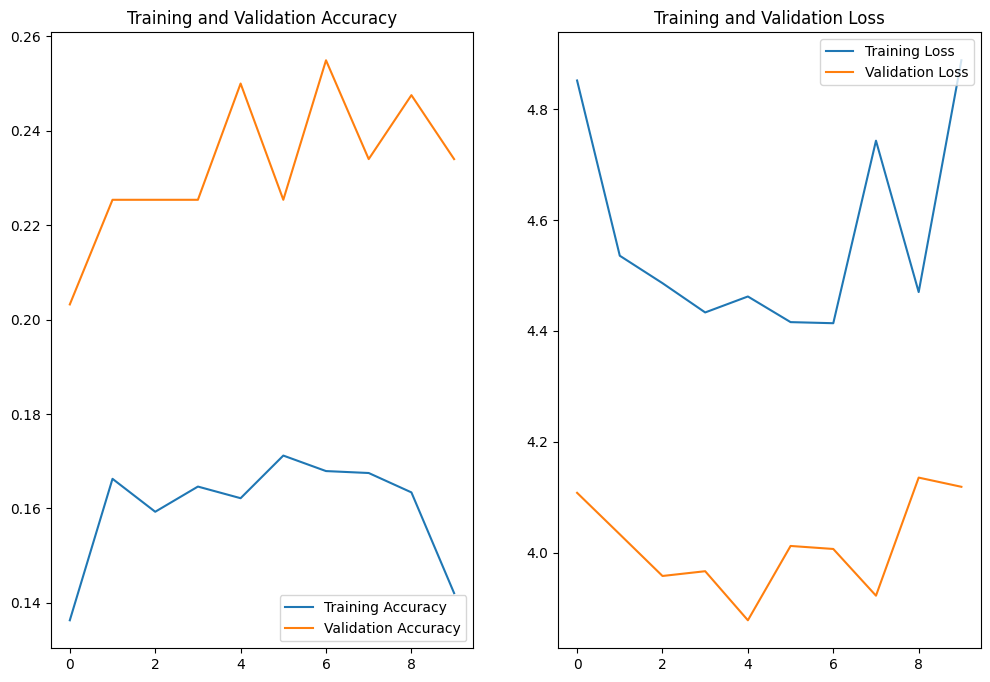

26/26 [==============================] - 0s 6ms/step - loss: 3.7337 - accuracy: 0.2438
Train Accuracy: 23.15%
Validation Accuracy: 25.00%
Test Accuracy: 24.38%
26/26 [==============================] - 0s 4ms/step


In [13]:
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Set input shape and number of classes
input_shape = (128, 128, 3)
num_classes = y_train.shape[1]

# Create the model
model = create_cnn_model(input_shape, num_classes)

# Early stopping and callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    x_train, y_train,
    epochs=1000,
    batch_size=500,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping]
)

# Plot training and validation curves
def plot_training_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_training_curves(history)

# Evaluate the model on train, val, and test sets
train_loss, train_accuracy = model.evaluate(x_train, y_train)
val_loss, val_accuracy = model.evaluate(x_val, y_val)
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Get predictions
y_train_pred = model.predict(x_train)
y_val_pred = model.predict(x_val)
y_test_pred = model.predict(x_test)


# Convert predictions to binary (0 or 1) based on a threshold (e.g., 0.5)
y_train_pred_binary = (y_train_pred > 0.5).astype(int)
y_val_pred_binary = (y_val_pred > 0.5).astype(int)
y_test_pred_binary = (y_test_pred > 0.5).astype(int)





In [14]:
def evaluate_model(y_true, y_pred):
    cols=y.columns
    predcols=[]
    for col in cols:
        predcols.append(col+'_pred')

    y_pred_df = pd.DataFrame(y_pred, columns=predcols)
    y_true.reset_index(drop=True, inplace=True)
    y_pred_df.reset_index(drop=True, inplace=True)
    combined_df = pd.concat([y_true, y_pred_df], axis=1)
    rows=[]
    for col in cols:
        acc=accuracy_score(combined_df[col],combined_df[col+'_pred'])
        prec=precision_score(combined_df[col],combined_df[col+'_pred'])
        f1=f1_score(combined_df[col],combined_df[col+'_pred'])
        re=recall_score(combined_df[col],combined_df[col+'_pred'])
        rows.append([col,acc,prec,f1,re])
    df=pd.DataFrame(rows,columns=['Class','Accuracy','Precision','F1','Recall'])
    return df

df=evaluate_model(y_test,y_test_pred_binary)






/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defin

In [15]:
print(df)

   Class  Accuracy  Precision   F1  Recall
0    WNL  0.764778        0.0  0.0     0.0
1     DR  0.826355        0.0  0.0     0.0
2   ARMD  0.955665        0.0  0.0     0.0
3     MH  0.862069        0.0  0.0     0.0
4     DN  0.947044        0.0  0.0     0.0
5    MYA  0.950739        0.0  0.0     0.0
6   BRVO  0.963054        0.0  0.0     0.0
7   TSLN  0.921182        0.0  0.0     0.0
8    ERM  0.995074        0.0  0.0     0.0
9     LS  0.982759        0.0  0.0     0.0
10    MS  0.987685        0.0  0.0     0.0
11   CSR  0.980296        0.0  0.0     0.0
12   ODC  0.875616        0.0  0.0     0.0
13  CRVO  0.987685        0.0  0.0     0.0
14    TV  0.993842        0.0  0.0     0.0
15    AH  0.996305        0.0  0.0     0.0
16   ODP  0.960591        0.0  0.0     0.0
17   ODE  0.966749        0.0  0.0     0.0
18    ST  0.995074        0.0  0.0     0.0
19  AION  0.995074        0.0  0.0     0.0
20    PT  0.995074        0.0  0.0     0.0
21    RT  0.977833        0.0  0.0     0.0
22    RS  0